## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer
from src.evaluation import GridAccuracyCalculator

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")

✓ 模块导入成功
✓ Matplotlib 中文支持已配置


## 2. 初始化OCR识别器

In [2]:
# 初始化识别器(仅OCR,不使用BERT)
recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'
)

print("\n模型信息:")
model_info = recognizer.get_model_info()
for key, value in model_info.items():
    print(f"  {key}: {value}")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
c:\Users\Quenton\Documents\Github\writtingOC

找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec
  num_characters: 18385
  blank_index: 0
  preprocessors: ['Read', 'ReisizeNorm', 'ToBatch']
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec


## 3. 加载测试数据

In [3]:
# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

# 3. 清理 ground truth
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 加载 Ground Truth: {len(gt_clean)} 字符")
print(f"前 50 字符: {gt_clean[:50]}")

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 550 字符
前 50 字符: 親愛的你：你好！我是一名普通的香港人。首先，請容許我爲自己的俗氣致歉。畢竟我倆素未謀面，再加上我是一


## 4. 格子检测与分割

In [4]:
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells

# 转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像
print("\n过滤非空格子...")
cell_images = []
non_empty_cells = []

for i, cell in enumerate(cells):  # 添加enumerate获取索引
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)
        if h > 2*crop and w > 2*crop:
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell
        
        # 判断非空
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ Ground Truth 字符数: {len(gt_clean)}")
print(f"✓ 非空格子数: {len(cell_images)}")

检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子...
✓ Ground Truth 字符数: 550
✓ 非空格子数: 532
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子...
✓ Ground Truth 字符数: 550
✓ 非空格子数: 532


## 5. 预处理方法定义

定义多种预处理方法供对比测试

In [5]:
def preprocess_baseline(img):
    """Baseline: 当前预处理流程(仅灰度化)"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def preprocess_adaptive_threshold(img):
    """Method 1: 自适应二值化"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 自适应阈值(Gaussian窗口)
    adaptive = cv2.adaptiveThreshold(
        gray, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY,
        blockSize=11,  # 窗口大小
        C=2  # 常数偏移
    )
    return adaptive

def preprocess_resize_normalize(img, target_height=48):
    """Method 2: 格子尺寸标准化"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    
    # 计算缩放比例(保持宽高比)
    scale = target_height / h
    new_w = int(w * scale)
    new_h = target_height
    
    # Resize
    resized = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    
    # Padding到正方形(可选)
    if new_w < target_height:
        pad_left = (target_height - new_w) // 2
        pad_right = target_height - new_w - pad_left
        resized = cv2.copyMakeBorder(resized, 0, 0, pad_left, pad_right, 
                                     cv2.BORDER_CONSTANT, value=255)
    
    return resized

def preprocess_enhancement(img):
    """Method 3: 字符增强(去噪+锐化)"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. 去噪(形态学开运算)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel_open)
    
    # 2. 连接断笔(形态学闭运算)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
    
    # 3. 锐化(拉普拉斯算子)
    laplacian = cv2.Laplacian(closed, cv2.CV_64F)
    sharpened = closed - 0.5 * laplacian
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened

# 预处理方法字典
preprocessing_methods = {
    'baseline': preprocess_baseline,
    'adaptive_threshold': preprocess_adaptive_threshold,
    'resize_normalize': preprocess_resize_normalize,
    'enhancement': preprocess_enhancement
}

print("✓ 定义了 4 种预处理方法")
for name in preprocessing_methods.keys():
    print(f"  - {name}")

✓ 定义了 4 种预处理方法
  - baseline
  - adaptive_threshold
  - resize_normalize
  - enhancement


## 6. 可视化预处理效果

随机选择5个格子,展示不同预处理方法的效果

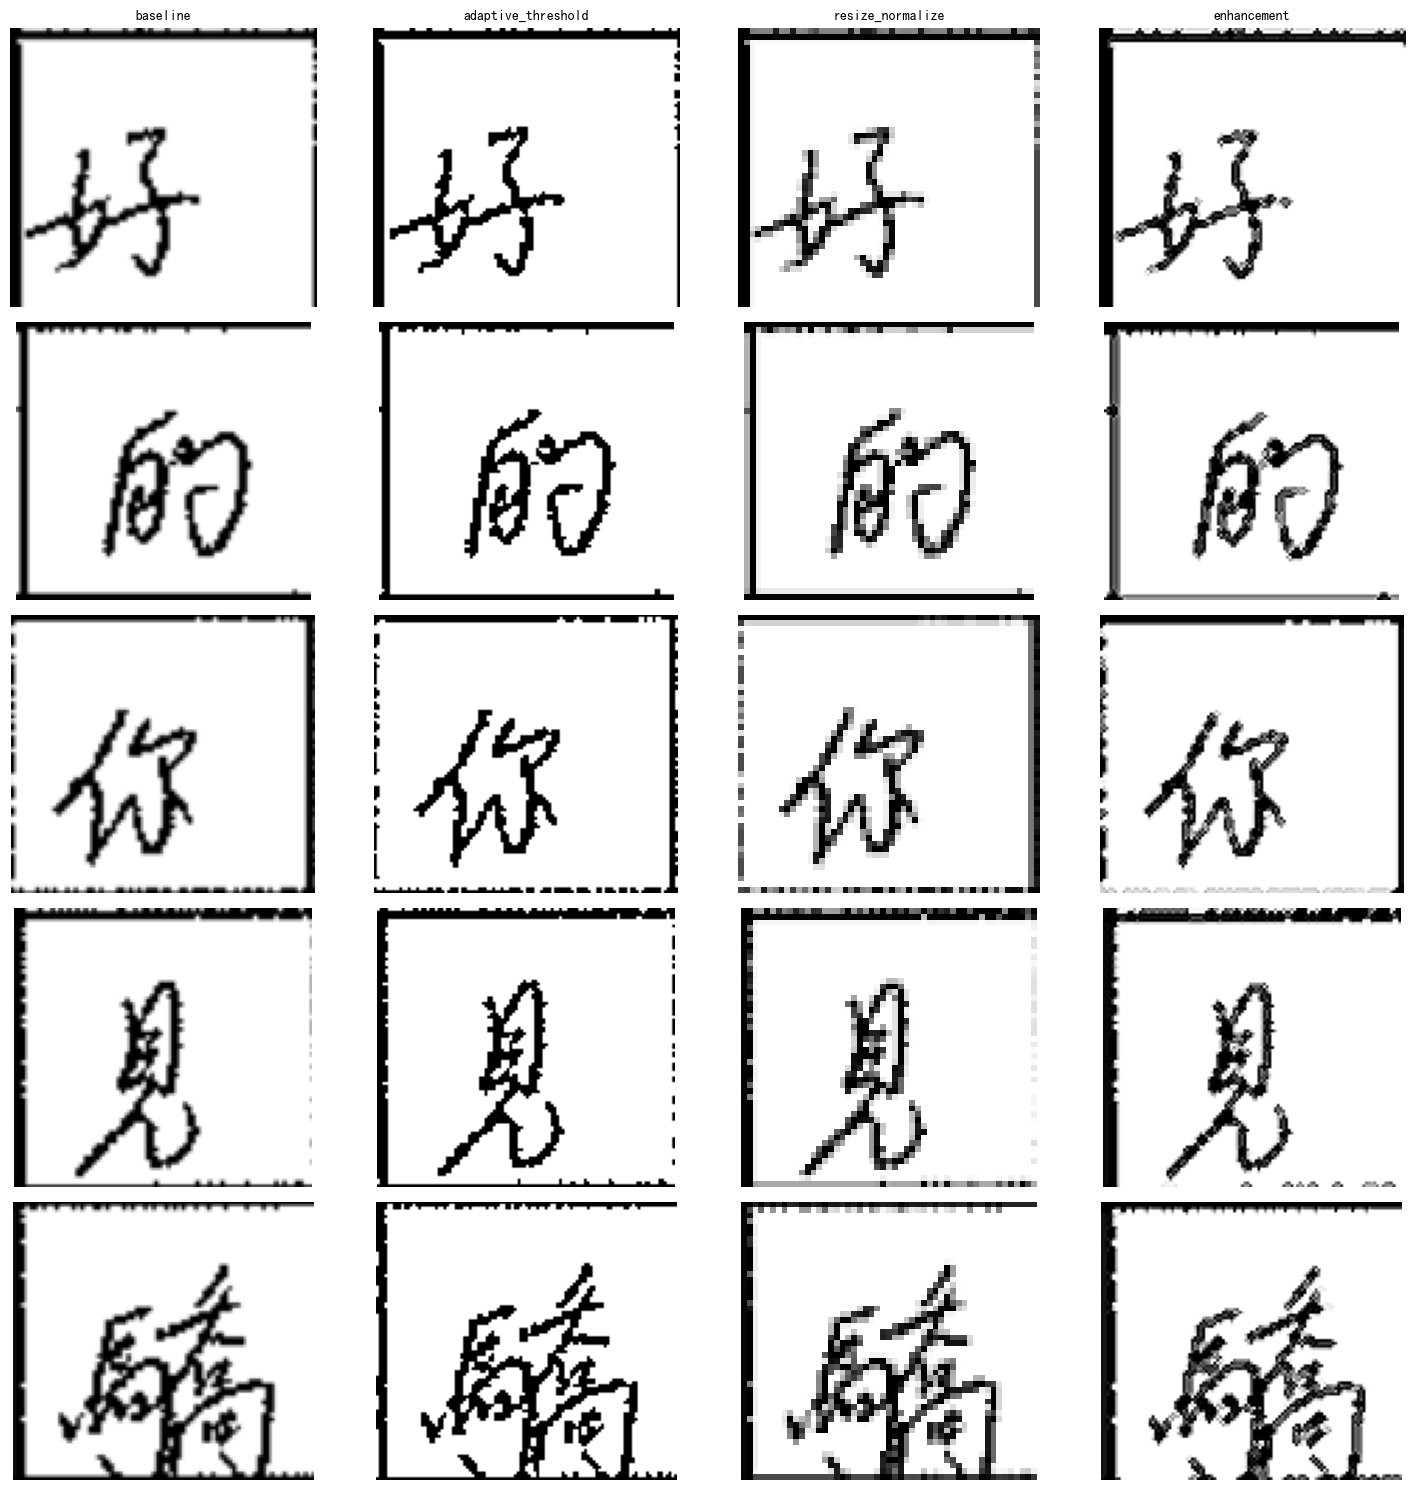


✓ 可视化完成


In [6]:
# 随机选择5个格子
np.random.seed(42)
sample_indices = np.random.choice(len(cell_images), size=min(5, len(cell_images)), replace=False)

# 可视化
fig, axes = plt.subplots(len(sample_indices), len(preprocessing_methods), 
                         figsize=(15, 3*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    cell_img = cell_images[idx]
    
    for j, (method_name, method_func) in enumerate(preprocessing_methods.items()):
        # 应用预处理
        processed = method_func(cell_img)
        
        # 显示
        ax = axes[i, j] if len(sample_indices) > 1 else axes[j]
        ax.imshow(processed, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(method_name, fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ 可视化完成")

## 7. 批量OCR识别(不使用BERT)

对每种预处理方法,执行纯OCR识别并计算准确率

In [7]:
def batch_recognize(cell_images, preprocess_func, recognizer):
    """批量识别(纯OCR,不使用BERT)"""
    results = []
    
    for img in tqdm(cell_images, desc="识别中"):
        # 预处理
        processed = preprocess_func(img)
        
        # 保存临时图像(PaddleOCR需要文件路径)
        import tempfile
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
            cv2.imwrite(tmp.name, processed)
            tmp_path = tmp.name
        
        # OCR识别 (使用PaddleOCR的text_rec)
        try:
            rec_result = recognizer.text_rec.predict(tmp_path)
            
            # 提取Top-1文本 (PaddleOCR返回格式: [{'rec_text': '文本', 'rec_score': 置信度}])
            if rec_result and len(rec_result) > 0:
                res_dict = rec_result[0]
                text = res_dict.get('rec_text', '')
                confidence = res_dict.get('rec_score', 0.0)
            else:
                text, confidence = '', 0.0
        finally:
            # 删除临时文件
            import os
            os.unlink(tmp_path)
        
        results.append({
            'text': text,
            'confidence': confidence
        })
    
    return results

def calculate_simple_accuracy(predicted_text, ground_truth_text):
    """简单字符准确率计算(用于预处理对比)"""
    import difflib
    
    # 使用 difflib 进行序列对齐（正确处理散布的缺失字符）
    matcher = difflib.SequenceMatcher(None, predicted_text, ground_truth_text)
    
    # 计算匹配的字符数（通过匹配块的大小之和）
    matches = sum(block.size for block in matcher.get_matching_blocks())
    
    total_chars = len(ground_truth_text)
    similarity = matcher.ratio()
    
    return {
        'accuracy': (matches / total_chars) if total_chars > 0 else 0,
        'correct_chars': matches,
        'total_chars': total_chars,
        'similarity': similarity
    }

print("✓ 定义了批量识别和准确率计算函数")

✓ 定义了批量识别和准确率计算函数


## 8. 执行对比实验

In [8]:
# 存储所有结果
all_results = {}

for method_name, method_func in preprocessing_methods.items():
    print(f"\n{'='*50}")
    print(f"测试方法: {method_name}")
    print(f"{'='*50}")
    
    # 批量识别
    results = batch_recognize(cell_images, method_func, recognizer)
    
    # 提取识别文本
    predicted_text = ''.join([r['text'] for r in results])
    
    # 计算准确率
    accuracy_result = calculate_simple_accuracy(predicted_text, gt_clean)
    
    # 保存结果
    all_results[method_name] = {
        'results': results,
        'predicted_text': predicted_text,
        'accuracy': accuracy_result
    }
    
    # 打印结果
    print(f"\n准确率: {accuracy_result['accuracy']:.2%}")
    print(f"正确字符数: {accuracy_result['correct_chars']}/{accuracy_result['total_chars']}")
    print(f"平均置信度: {np.mean([r['confidence'] for r in results]):.4f}")

print("\n✓ 所有实验完成")


测试方法: baseline


识别中: 100%|██████████| 532/532 [00:10<00:00, 50.81it/s]




准确率: 67.64%
正确字符数: 372/550
平均置信度: 0.7436

测试方法: adaptive_threshold


识别中: 100%|██████████| 532/532 [00:09<00:00, 56.46it/s]



准确率: 65.09%
正确字符数: 358/550
平均置信度: 0.7189

测试方法: resize_normalize


识别中: 100%|██████████| 532/532 [00:11<00:00, 47.61it/s]



准确率: 67.82%
正确字符数: 373/550
平均置信度: 0.7411

测试方法: enhancement


识别中: 100%|██████████| 532/532 [00:11<00:00, 45.74it/s]


准确率: 64.55%
正确字符数: 355/550
平均置信度: 0.7170

✓ 所有实验完成


## 9. 结果汇总与对比

In [9]:
import pandas as pd

# 汇总结果
summary = []
for method_name, result in all_results.items():
    acc = result['accuracy']
    avg_conf = np.mean([r['confidence'] for r in result['results']])
    
    summary.append({
        '预处理方法': method_name,
        '准确率': f"{acc['accuracy']:.2%}",
        '正确字符数': f"{acc['correct_chars']}/{acc['total_chars']}",
        '平均置信度': f"{avg_conf:.4f}"
    })

df_summary = pd.DataFrame(summary)
print("\n" + "="*60)
print("实验结果汇总")
print("="*60)
print(df_summary.to_string(index=False))

# 计算相对baseline的提升
baseline_acc = all_results['baseline']['accuracy']['accuracy']
print(f"\n{'='*60}")
print("相对Baseline的提升")
print("="*60)
for method_name, result in all_results.items():
    if method_name != 'baseline':
        acc = result['accuracy']['accuracy']
        diff = acc - baseline_acc
        print(f"{method_name:25s}: {diff:+.2%} ({acc:.2%} vs {baseline_acc:.2%})")


实验结果汇总
             预处理方法    准确率   正确字符数  平均置信度
          baseline 67.64% 372/550 0.7436
adaptive_threshold 65.09% 358/550 0.7189
  resize_normalize 67.82% 373/550 0.7411
       enhancement 64.55% 355/550 0.7170

相对Baseline的提升
adaptive_threshold       : -2.55% (65.09% vs 67.64%)
resize_normalize         : +0.18% (67.82% vs 67.64%)
enhancement              : -3.09% (64.55% vs 67.64%)


## 10. 保存实验结果

In [10]:
import json
from datetime import datetime

# 准备保存的数据
save_data = {
    'experiment_info': {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'image_path': str(img_path),
        'ground_truth_length': len(gt_clean),
        'cell_count': len(cell_images)
    },
    'results': {}
}

for method_name, result in all_results.items():
    save_data['results'][method_name] = {
        'accuracy': result['accuracy']['accuracy'],
        'correct_chars': result['accuracy']['correct_chars'],
        'total_chars': result['accuracy']['total_chars'],
        'avg_confidence': float(np.mean([r['confidence'] for r in result['results']]))
    }

# 保存到文件
output_path = project_root / 'output' / 'preprocessing_comparison_results.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(save_data, f, ensure_ascii=False, indent=2)

print(f"✓ 结果已保存到: {output_path}")

✓ 结果已保存到: C:\Users\Quenton\Documents\Github\writtingOCR\output\preprocessing_comparison_results.json


## 11. 错误案例分析(可选)

对比不同预处理方法在哪些格子上产生了差异

In [11]:
# 找出baseline和最佳方法的差异案例
baseline_texts = [r['text'] for r in all_results['baseline']['results']]

print("\n差异案例分析:")
print("="*60)

for method_name, result in all_results.items():
    if method_name == 'baseline':
        continue
    
    method_texts = [r['text'] for r in result['results']]
    
    # 找出差异
    differences = []
    for i, (base_text, method_text, gt_char) in enumerate(zip(baseline_texts, method_texts, gt_clean)):
        if base_text != method_text:
            differences.append({
                'index': i,
                'gt': gt_char,
                'baseline': base_text,
                'method': method_text,
                'baseline_correct': base_text == gt_char,
                'method_correct': method_text == gt_char
            })
    
    print(f"\n{method_name}: {len(differences)} 个差异")
    
    # 统计改进/恶化
    improved = sum(1 for d in differences if not d['baseline_correct'] and d['method_correct'])
    degraded = sum(1 for d in differences if d['baseline_correct'] and not d['method_correct'])
    
    print(f"  改进: {improved} 个")
    print(f"  恶化: {degraded} 个")
    print(f"  净提升: {improved - degraded:+d} 个")
    
    # 显示前5个改进案例
    if improved > 0:
        print("\n  改进案例(前5个):")
        improved_cases = [d for d in differences if not d['baseline_correct'] and d['method_correct']]
        for case in improved_cases[:5]:
            print(f"    格子{case['index']}: GT='{case['gt']}' | Baseline='{case['baseline']}' → {method_name}='{case['method']}'")


差异案例分析:

adaptive_threshold: 67 个差异
  改进: 0 个
  恶化: 3 个
  净提升: -3 个

resize_normalize: 52 个差异
  改进: 3 个
  恶化: 1 个
  净提升: +2 个

  改进案例(前5个):
    格子7: GT='！' | Baseline='1' → resize_normalize='！'
    格子36: GT='竟' | Baseline='竞' → resize_normalize='竟'
    格子154: GT='匆' | Baseline='勿' → resize_normalize='匆'

enhancement: 71 个差异
  改进: 1 个
  恶化: 1 个
  净提升: +0 个

  改进案例(前5个):
    格子7: GT='！' | Baseline='1' → enhancement='！'


## 12. 辅助函数定义（来自02.8）

定义可视化所需的辅助函数

In [12]:
def restore_empty_cells(results_list, cells, non_empty_cells):
    """
    恢复空格子，构建完整的预测结果
    
    参数:
        results_list: OCR识别结果列表（非空格子）
        cells: 所有格子列表（包括空格子）
        non_empty_cells: 非空格子列表
        
    返回:
        prediction_data_full: 完整预测结果（包含空格子）
    """
    # 1. 创建完整的格子字典（包括空格子）
    all_cells_dict = {}
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',           # 默认为空
            'confidence': 1.0,    # 空格子置信度设为 1.0
            'is_empty': True      # 标记为空格子
        }
    
    # 2. 填充非空格子的识别结果
    for i, (result, cell) in enumerate(zip(results_list, non_empty_cells)):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result  # 保存完整的 OCR 结果（包含 top_k 等）
        }
    
    # 3. 转换为列表（按 row, col 排序）
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full


print("✓ 辅助函数定义完成")

✓ 辅助函数定义完成


## 13. 可视化网格对比

通过颜色编码直观展示不同预处理方法的识别效果
- 🟢 绿色：识别正确
- 🔴 红色：识别错误  
- 🟡 黄色：空格子（被过滤）

生成可视化网格对比...
网格尺寸: 29 行 × 20 列
显示范围: 22 行 × 20 列


C:\Users\Quenton\AppData\Local\Temp\ipykernel_41220\522364303.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(pad=0.1)


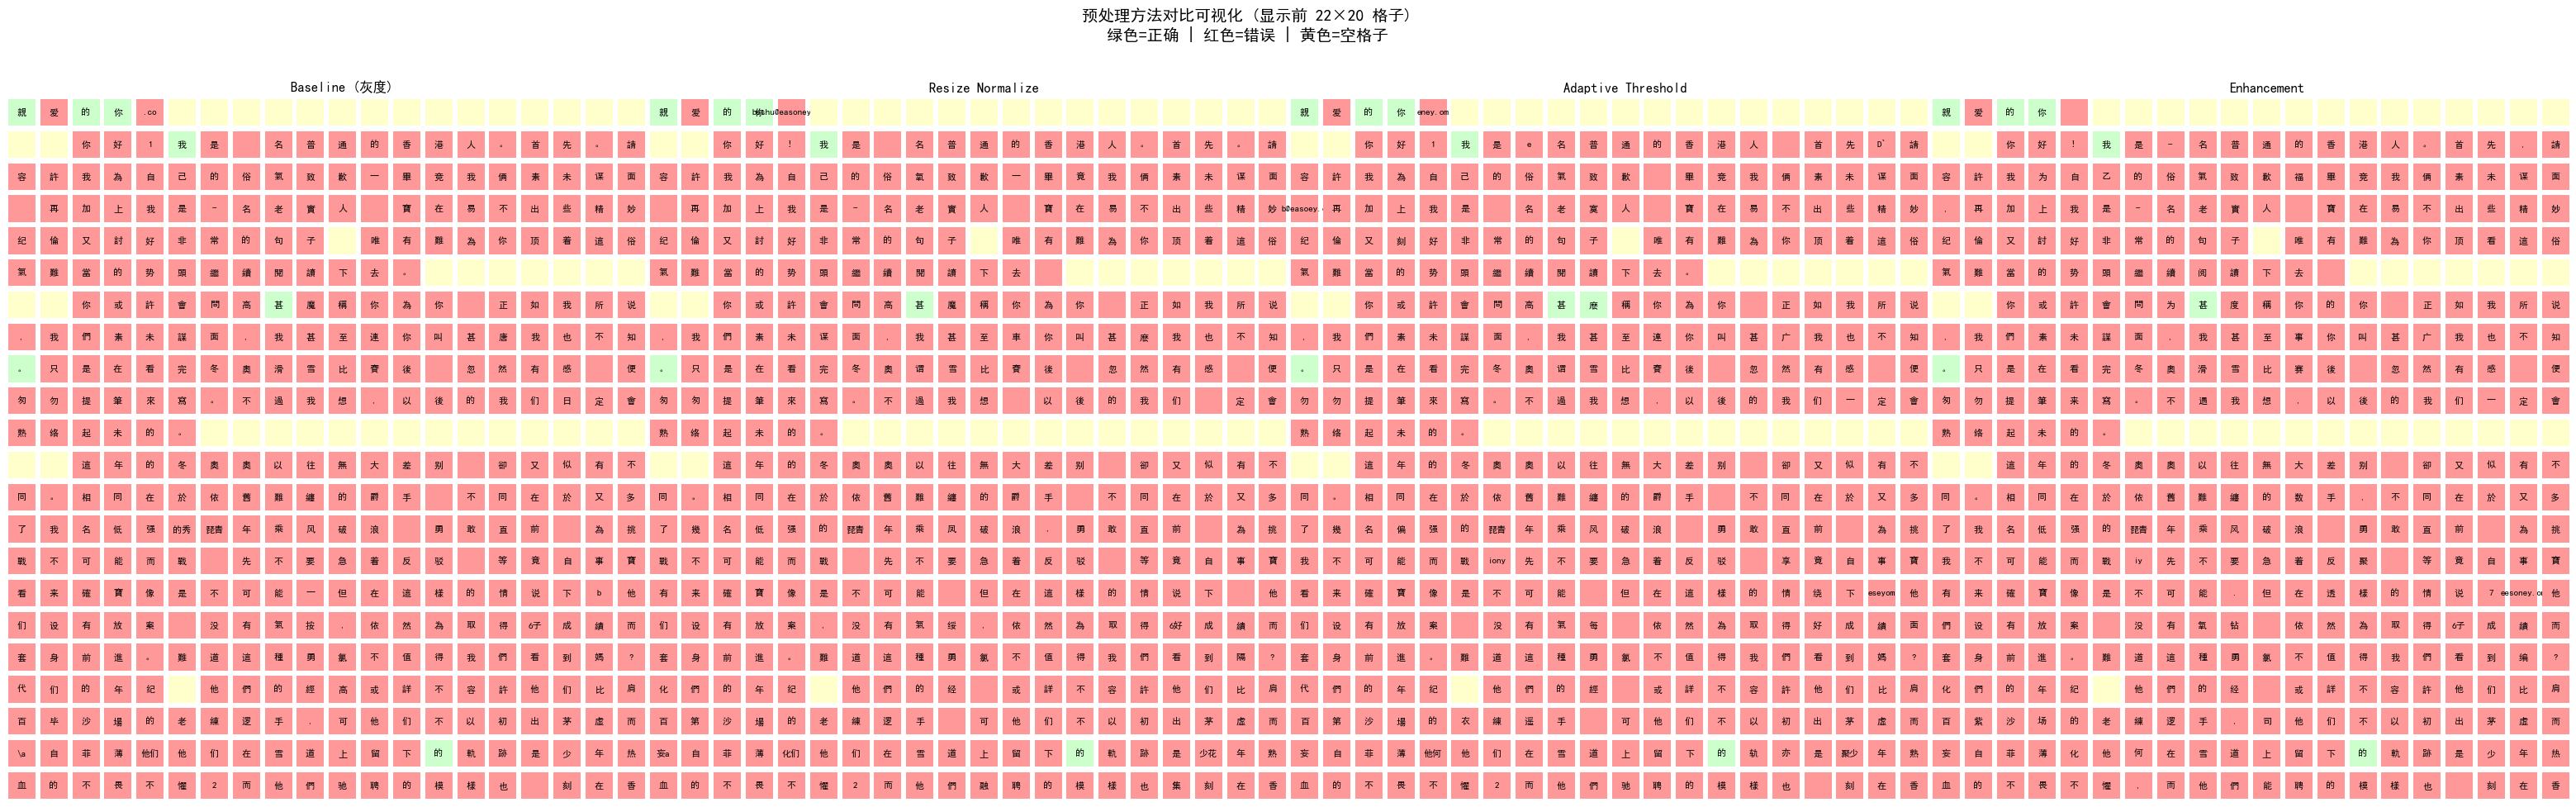


可视化范围内的准确率统计
Baseline (灰度)            :   7/396 = 1.77%
Resize Normalize         :   7/396 = 1.77%
Adaptive Threshold       :   8/396 = 2.02%
Enhancement              :   7/396 = 1.77%


In [13]:
# 可视化网格对比（完全参考02.8的实现）
print("生成可视化网格对比...")

# 选择要对比的方法
methods_to_visualize = ['baseline', 'resize_normalize', 'adaptive_threshold', 'enhancement']
method_titles = ['Baseline (灰度)', 'Resize Normalize', 'Adaptive Threshold', 'Enhancement']

# 为每种方法恢复完整的格子数据（包含空格子）
method_full_data = {}
for method_name in methods_to_visualize:
    results = all_results[method_name]['results']
    full_data = restore_empty_cells(results, cells, non_empty_cells)
    method_full_data[method_name] = full_data

# 获取网格大小
rows = max(cell['row'] for cell in cells) + 1
cols = max(cell['col'] for cell in cells) + 1
print(f"网格尺寸: {rows} 行 × {cols} 列")

# 限制显示范围
max_display_rows = min(rows, 22)
max_display_cols = min(cols, 25)
print(f"显示范围: {max_display_rows} 行 × {max_display_cols} 列")

# 创建4张子图（横向排列）
fig, axes = plt.subplots(max_display_rows, max_display_cols * 4, 
                         figsize=(max_display_cols * 4 * 0.5, max_display_rows * 0.5))

# 确保axes是二维数组
if max_display_rows == 1:
    axes = axes.reshape(1, -1)

# 遍历每种方法
for method_idx, method_name in enumerate(methods_to_visualize):
    full_data = method_full_data[method_name]
    
    # 创建格子索引字典（参考02.8）
    cell_dict = {}
    for i, cell_data in enumerate(full_data):
        cell_dict[(cell_data['row'], cell_data['col'])] = i
    
    # 遍历网格
    for row in range(max_display_rows):
        for col in range(max_display_cols):
            # 计算当前方法对应的列索引
            ax_col = method_idx * max_display_cols + col
            ax = axes[row, ax_col]
            ax.axis('off')
            
            # 获取格子索引
            if (row, col) not in cell_dict:
                # 空格子或超出范围，显示灰色
                ax.imshow(np.ones((50, 50, 3)) * 0.9)
                continue
            
            idx = cell_dict[(row, col)]
            cell_data = full_data[idx]
            pred_text = cell_data['text']
            
            # 获取对应的 GT 字符（直接用 idx）
            gt_text = gt_clean[idx] if idx < len(gt_clean) else ''
            
            # 判断格子状态
            if cell_data.get('is_empty', False):
                # 空格子 - 浅黄色
                color = [1.0, 1.0, 0.8]
            elif pred_text == gt_text:
                # 识别正确 - 浅绿色
                color = [0.8, 1.0, 0.8]
            else:
                # 识别错误 - 浅红色
                color = [1.0, 0.6, 0.6]
            
            # 显示颜色块
            ax.imshow(np.ones((50, 50, 3)) * np.array(color))
            
            # 添加文本标签
            if pred_text != '':
                ax.text(0.5, 0.5, pred_text, 
                       ha='center', va='center', fontsize=8,
                       transform=ax.transAxes, weight='bold')

# 添加方法标题
for method_idx, title in enumerate(method_titles):
    # 在第一行上方添加标题
    center_col = method_idx * max_display_cols + max_display_cols // 2
    axes[0, center_col].text(0.5, 1.2, title,
                             ha='center', va='bottom',
                             transform=axes[0, center_col].transAxes,
                             fontsize=12, weight='bold')

plt.tight_layout(pad=0.1)
plt.suptitle(f'预处理方法对比可视化 (显示前 {max_display_rows}×{max_display_cols} 格子)\n'
             f'绿色=正确 | 红色=错误 | 黄色=空格子',
             fontsize=14, y=0.98)
plt.show()

# 统计每种方法的正确率
print("\n" + "="*60)
print("可视化范围内的准确率统计")
print("="*60)

for method_name, title in zip(methods_to_visualize, method_titles):
    full_data = method_full_data[method_name]
    
    # 创建格子索引字典
    cell_dict = {}
    for i, cell_data in enumerate(full_data):
        cell_dict[(cell_data['row'], cell_data['col'])] = i
    
    correct = 0
    total = 0
    
    for row in range(max_display_rows):
        for col in range(max_display_cols):
            if (row, col) in cell_dict:
                idx = cell_dict[(row, col)]
                cell_data = full_data[idx]
                
                if not cell_data.get('is_empty', False):
                    pred_text = cell_data['text']
                    gt_text = gt_clean[idx] if idx < len(gt_clean) else ''
                    total += 1
                    if pred_text == gt_text:
                        correct += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"{title:25s}: {correct:3d}/{total:3d} = {accuracy:.2%}")